# Bayesian linear regression

Example following: https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211



In [90]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [35]:
x = [
   -1.64934805,  0.52925273,  1.10100092,  0.38566793, -1.56768245,
    1.26195686,  0.92613986, -0.23942803,  0.33933045,  1.14390657,
    # 0.65466195, -1.36229805, -0.32393554, -0.23258941,  0.17688024,
    # 1.60774334, -0.22801156,  1.53008133, -1.31431042, -0.27699609
] # inputs
y = [
   -3.67385666,  3.37543275,  6.25390538,  1.41569973, -2.08413872,
    6.71560158,  6.32344159,  2.40651236,  4.54217349,  6.25778739,
    # 4.98933806, -2.69713137,  1.45705571, -0.49772953,  1.50502898,
    # 7.27228263,  1.6267433 ,  6.43580518, -0.50291509,  0.65674682
] # outputs

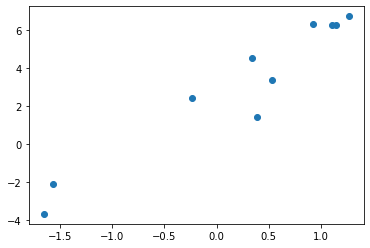

In [40]:
plt.scatter(x,y)

In [36]:
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


array([<AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'error'}>], dtype=object)

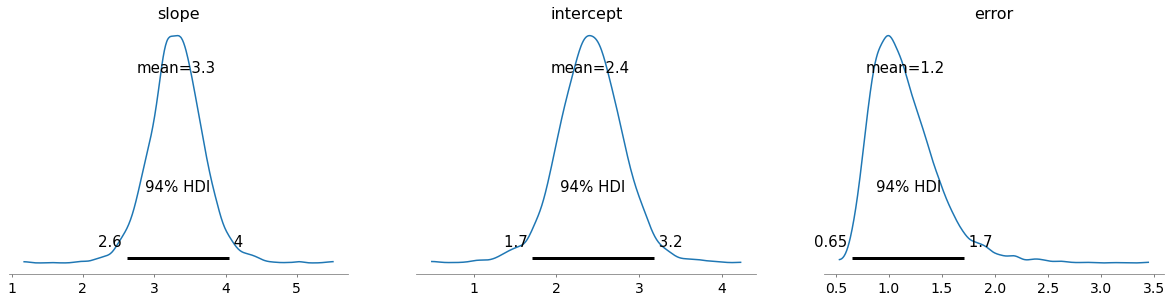

In [37]:

with pm.Model() as predictive_model:
    # define priors
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)

    x_ = pm.Data('features', x) # a data container, can be changed
    
    # predictions
    obs = pm.Normal('observation', a*x_ + b, s, observed=y)
    
    # use MCMC to sample
    trace = pm.sample(return_inferencedata=True)
    
az.plot_posterior(trace)

In [41]:
x_new = np.linspace(-3, 3, 50) # 50 input values between -3 and 3
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

In [42]:
y_pred = posterior['observation']

In [43]:
y_pred.shape, x_new.shape

((4000, 50), (50,))

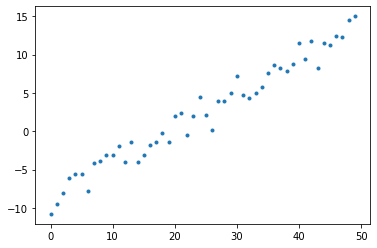

In [44]:
plt.plot(y_pred[0,:],'.')

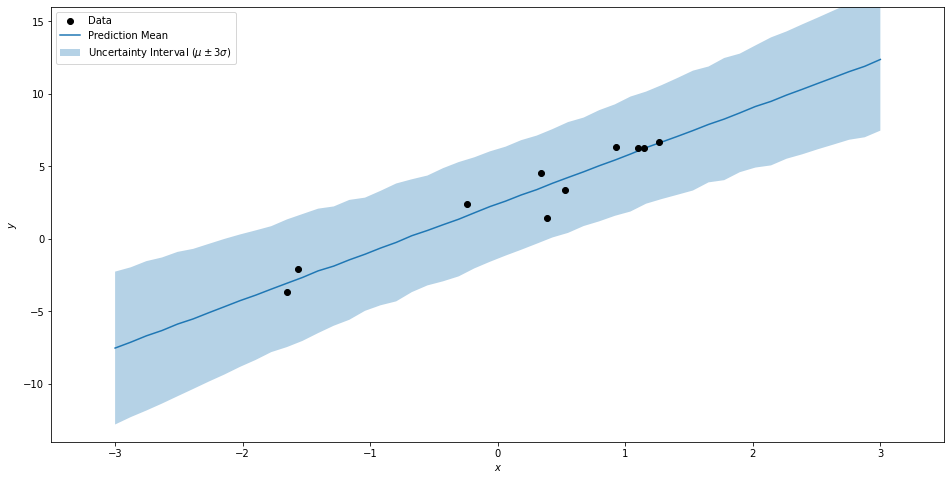

In [88]:
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(16, 8))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
x_plot = np.linspace(-3,3)
n_plot = 100
# for i in range(n_plot):
#     plt.plot(x_plot, trace.posterior['slope'][0,i].data *x_plot + trace.posterior['intercept'][0,i].data, 'k', alpha=3/n_plot)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-14, 16)
plt.xlim(-3.5,3.5)
plt.legend(loc='upper left')

In [46]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=predictive_model)

/Users/flow/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [47]:
ppc

{'observation': array([[-8.25647138, -7.34802463, -7.10056024, ..., 16.54436798,
         12.07019847, 13.95724552],
        [-8.2566163 , -6.9190569 , -6.69297503, ..., 12.38852173,
         11.1275405 , 13.61251355],
        [-8.2183769 , -7.46298501, -6.80836432, ..., 12.51386116,
         12.33798485, 11.93487033],
        ...,
        [-6.67846978, -4.77147392, -6.19010667, ..., 12.04546662,
         11.50737139, 13.44652209],
        [-8.47333095, -7.98053919, -7.89360997, ..., 12.69488366,
         13.06450282, 13.26112414],
        [-7.89951197, -6.93389872, -7.73833625, ..., 13.82412454,
         13.38084227, 12.61426959]])}

In [54]:
trace.posterior['slope'].shape

(4, 1000)

In [55]:
trace.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    slope      (chain, draw) float64 3.554 3.286 3.635 ... 3.198 3.371 3.577
    intercept  (chain, draw) float64 2.68 2.385 2.606 ... 2.197 2.211 2.286
    error      (chain, draw) float64 1.341 0.9015 0.9806 ... 1.148 1.523 0.8341
Attributes:
    created_at:                 2022-04-22T00:26:10.479968
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              14.363311052322388
    tuning_steps:               1000

In [99]:
def plot_posterior_pred(n_plot=100):
    plt.figure(figsize=(10,6))
    x_plot = np.linspace(-3,3)
    for i in range(n_plot):
        plt.plot(x_plot, trace.posterior['slope'][0,i].data *x_plot + trace.posterior['intercept'][0,i].data, 'k', alpha=3/n_plot)
    plt.scatter(x, y, c='k', zorder=10, label='Data')
    plt.xlim([-3.5,3.5])
    plt.ylim([-15,20])


In [101]:
interact(plot_posterior_pred, n_plot=widgets.IntSlider(min=0, max=1000, step=10, value=0));

interactive(children=(IntSlider(value=0, description='n_plot', max=1000, step=10), Output()), _dom_classes=('w…

In [69]:
trace.posterior['slope'][0,0].data * x_plot

array([-10.66260998, -10.22740141,  -9.79219284,  -9.35698427,
        -8.9217757 ,  -8.48656713,  -8.05135856,  -7.61614999,
        -7.18094142,  -6.74573285,  -6.31052428,  -5.87531571,
        -5.44010713,  -5.00489856,  -4.56968999,  -4.13448142,
        -3.69927285,  -3.26406428,  -2.82885571,  -2.39364714,
        -1.95843857,  -1.52323   ,  -1.08802143,  -0.65281286,
        -0.21760429,   0.21760429,   0.65281286,   1.08802143,
         1.52323   ,   1.95843857,   2.39364714,   2.82885571,
         3.26406428,   3.69927285,   4.13448142,   4.56968999,
         5.00489856,   5.44010713,   5.87531571,   6.31052428,
         6.74573285,   7.18094142,   7.61614999,   8.05135856,
         8.48656713,   8.9217757 ,   9.35698427,   9.79219284,
        10.22740141,  10.66260998])

In [66]:
tmp.data

array(3.55420333)

In [61]:
x_plot

array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
       -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
       -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
       -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
       -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
        0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
        0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.16326531,
        1.28571429,  1.40816327,  1.53061224,  1.65306122,  1.7755102 ,
        1.89795918,  2.02040816,  2.14285714,  2.26530612,  2.3877551 ,
        2.51020408,  2.63265306,  2.75510204,  2.87755102,  3.        ])